In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import RepeatedStratifiedKFold,GridSearchCV,cross_validate,permutation_test_score
from sklearn.linear_model import Lasso
from functools import reduce

In [2]:
demo = pd.read_sas('DEMO_J.XPT')
demo.head()

,SEQN,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDAGEMN,RIDRETH1,RIDRETH3,RIDEXMON,RIDEXAGM,...,DMDHREDZ,DMDHRMAZ,DMDHSEDZ,WTINT2YR,WTMEC2YR,SDMVPSU,SDMVSTRA,INDHHIN2,INDFMIN2,INDFMPIR
0,93703.0,10.0,2.0,2.0,2.0,NaN,5.0,6.0,2.0,27.0,...,3.0,1.0,3.0,9246.491865,8539.731348,2.0,145.0,15.0,15.0,5.00
1,93704.0,10.0,2.0,1.0,2.0,NaN,3.0,3.0,1.0,33.0,...,3.0,1.0,2.0,37338.768343,42566.614750,1.0,143.0,15.0,15.0,5.00
2,93705.0,10.0,2.0,2.0,66.0,NaN,4.0,4.0,2.0,NaN,...,1.0,2.0,NaN,8614.571172,8338.419786,2.0,145.0,3.0,3.0,0.82
3,93706.0,10.0,2.0,1.0,18.0,NaN,5.0,6.0,2.0,222.0,...,3.0,1.0,2.0,8548.632619,8723.439814,2.0,134.0,NaN,NaN,NaN
4,93707.0,10.0,2.0,1.0,13.0,NaN,5.0,7.0,2.0,158.0,...,2.0,1.0,3.0,6769.344567,7064.609730,1.0,138.0,10.0,10.0,1.88


In [3]:
demo.columns

Index(['SEQN', 'SDDSRVYR', 'RIDSTATR', 'RIAGENDR', 'RIDAGEYR', 'RIDAGEMN',
       'RIDRETH1', 'RIDRETH3', 'RIDEXMON', 'RIDEXAGM', 'DMQMILIZ', 'DMQADFC',
       'DMDBORN4', 'DMDCITZN', 'DMDYRSUS', 'DMDEDUC3', 'DMDEDUC2', 'DMDMARTL',
       'RIDEXPRG', 'SIALANG', 'SIAPROXY', 'SIAINTRP', 'FIALANG', 'FIAPROXY',
       'FIAINTRP', 'MIALANG', 'MIAPROXY', 'MIAINTRP', 'AIALANGA', 'DMDHHSIZ',
       'DMDFMSIZ', 'DMDHHSZA', 'DMDHHSZB', 'DMDHHSZE', 'DMDHRGND', 'DMDHRAGZ',
       'DMDHREDZ', 'DMDHRMAZ', 'DMDHSEDZ', 'WTINT2YR', 'WTMEC2YR', 'SDMVPSU',
       'SDMVSTRA', 'INDHHIN2', 'INDFMIN2', 'INDFMPIR'],
      dtype='object')

In [4]:
trigly = pd.read_sas('TRIGLY_J.XPT')
trigly.head()

,SEQN,WTSAF2YR,LBXTR,LBDTRSI,LBDLDL,LBDLDLSI,LBDLDLM,LBDLDMSI,LBDLDLN,LBDLDNSI
0,93708.0,2.565368e+04,58.0,0.655,109.0,2.819,107.0,2.767,111.0,2.870
1,93711.0,2.922605e+04,48.0,0.542,156.0,4.034,152.0,3.931,158.0,4.086
2,93717.0,1.371510e+05,102.0,1.152,140.0,3.620,138.0,3.569,142.0,3.672
3,93718.0,5.888331e+04,46.0,0.519,80.0,2.069,77.0,1.991,79.0,2.043
4,93719.0,5.397605e-79,80.0,0.903,35.0,0.905,35.0,0.905,35.0,0.905


In [5]:
ds = pd.DataFrame(trigly.SEQN)
ds['LBXTR'] = pd.DataFrame(trigly.LBXTR)
ds = ds.merge(demo)
ds = ds[['SEQN','LBXTR','RIAGENDR','RIDAGEYR']]

In [6]:
phy = pd.read_sas('PAQ_J.XPT')
phy = phy[~((phy == 9999)|(phy==5555)|(phy==7777)|(phy==6666)).any(axis='columns')]
phy = phy[['SEQN','PAD680']]
phy = phy.dropna()

In [7]:
smq = pd.read_sas('SMQ_J.XPT')
smq = smq[['SEQN','SMQ020']]

In [8]:
slq = pd.read_sas('SLQ_J.XPT')
slq = slq[['SEQN','SLD012']]

In [9]:
dpq = pd.read_sas('DPQ_J.XPT')
dpq['DPQ00'] = dpq['DPQ010'] + dpq['DPQ020'] + dpq['DPQ030'] + dpq['DPQ040'] + dpq['DPQ050'] + dpq['DPQ060'] + dpq['DPQ070'] + dpq['DPQ080'] + dpq['DPQ090']
dpq = dpq[['SEQN','DPQ00']]
dpq = dpq.dropna()

In [10]:
dbq = pd.read_sas('DBQ_J.XPT')
dbq = dbq[~((dbq == 9999)|(dbq==5555)|(dbq==7777)|(dbq==6666)).any(axis='columns')]
dbq = dbq[['SEQN','DBQ700','DBD900']]
dbq = dbq.dropna()

In [11]:
whq = pd.read_sas('WHQ_J.XPT')
whq = whq[~((whq == 9999)|(whq==5555)|(whq==7777)|(whq==6666)).any(axis='columns')]
whq = whq[['SEQN','WHD020']]
whq = whq.dropna()

In [12]:
# reduce(lambda x,y: pd.merge(x,y), [ds,dbq,phy,smq,dpq,whq,slq])

In [13]:
ds = pd.DataFrame(trigly.SEQN)
ds['LBXTR'] = pd.DataFrame(trigly.LBXTR)
ds = ds.merge(demo)
ds = ds[['SEQN','LBXTR','RIAGENDR','RIDAGEYR']]
ds = ds.merge(dbq)
ds = ds.merge(phy)
ds = ds.merge(smq)
ds = ds.merge(dpq)
ds = ds.merge(whq)
ds = ds.merge(slq)

In [14]:
# using Lasso to select features

In [15]:
clf = Lasso(random_state=1, max_iter=1000)

In [16]:
ds = ds.dropna()
X = ds[ds.columns[~ds.columns.isin(['SEQN','LBXTR'])]]

In [17]:
y = ds['LBXTR']

In [18]:
clf.fit(X,y)

Lasso(random_state=1)

In [19]:
# X.columns

In [20]:
# ['Gender','Age','Healthy Diet','Fastfood','SedentaryActivity','Smoking','Depression','Weight','Sleep']

In [21]:
coef = clf.coef_
xticks = ['Gender','Age','Healthy Diet','Fastfood','SedentaryActivity','Smoking','Depression','Weight','Sleep']

xticks = [xticks[i] for i in np.argsort(coef)]
coef = np.sort(coef)

<BarContainer object of 9 artists>

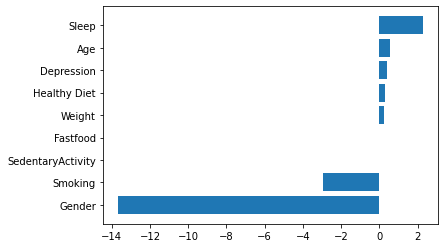

In [22]:
plt.barh(xticks,coef)

In [30]:
# The load on fastfood and sedentary activity is 0, I chose to drop them in the classification

In [23]:
# classfication

In [24]:
y_class = y>150

In [25]:
newX = X.drop(['DBD900','PAD680'],axis=1)

In [26]:
# use grid search CV to find hyperparameters

model = xgb.XGBClassifier(scale_pos_weight=5, # ratio: N negative vs N positive
                          eval_metric='logloss',
                         use_label_encoder=False)
param_dict = {'max_depth': [1,2,4,10],
              'learning_rate':[0.001, 0.01, 0.1, 0.2, 0.3],
             'n_estimators': [50,100,200,400]}

scoring = ['accuracy','precision','recall','f1']
clf = GridSearchCV(model, param_dict, scoring = scoring,refit = 'accuracy',return_train_score=True) # 5fold by default
clf.fit(newX,y_class)
print(clf.best_params_)

{'learning_rate': 0.3, 'max_depth': 10, 'n_estimators': 200}


In [27]:
# hyperparameter from grid search
model = xgb.XGBClassifier(
    max_depth = 10,
    learning_rate = 0.3,
    n_estimators = 200,
    scale_pos_weight=5,
    eval_metric='logloss',
    use_label_encoder=False)
model.fit(newX,y_class)

feature_importances = model.feature_importances_

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

scoring = ['accuracy','precision','recall']
cv_results = cross_validate(model,newX,y_class,scoring=scoring,cv=cv,return_train_score=True)
print('Stratified 10 Fold result:')
print('Testing Accuracy:',np.mean(cv_results['test_accuracy']))
print('Testing Precision:',np.mean(cv_results['test_precision']))
print('Testing Recall:',np.mean(cv_results['test_recall']))

Stratified 10 Fold result:
Testing Accuracy: 0.7280373090348611
Testing Precision: 0.2318355808979147
Testing Recall: 0.17727272727272725


In [31]:
# the scoring metrics are not ideal. it needs more model diagnosis steps

In [28]:
indices = np.argsort(feature_importances)[::-1]
xticks = ['Gender','Age','Healthy Diet','Smoking','Depression','Weight','Sleep']
feature_names = xticks

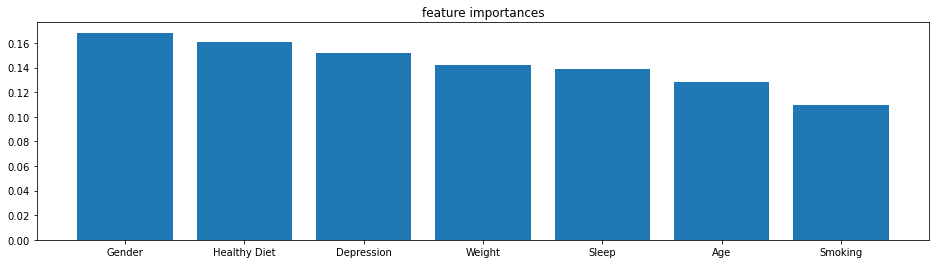

In [29]:
plt.figure(figsize=(16,4))
plt.title("feature importances")
plt.bar(range(len(feature_importances)), feature_importances[indices])
plt.xticks(range(len(feature_importances)), np.array(feature_names)[indices]);

In [32]:
# display the feature importance of trees